# LIBRARY AND CONFIGUATION

In [1]:
import pickle
import os
os.chdir('/home/pot/project/web-scan')
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    
import pathlib
import tensorflow.compat.v2 as tf
import cv2
import argparse
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
from helpers import load_label_map as label_map_util
from helpers import visualization_utils as viz_utils
from helpers import corner_utils, ocr_helpers

# LOAD SSD MOBILENET MODEL

In [2]:
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')


# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = '/home/pot/project/web-scan/models/discharge_record'
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = '/home/pot/project/web-scan/models/discharge_record/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = 0.8

# NUM_CLASSES
NUM_CLASSES = 13

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

# LOAD CATEGORY INDEX
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
num_classes = len(category_index)
list_class_init = set(list(category_index.keys()))

# CROP CORNER WITH OPENCV

In [3]:
# LOAD IMAGE TEST
img = ocr_helpers.read_image_from_dir(r'/home/pot/project/web-scan/test_data/discharge_record/7.jpg')
img = np.asarray(img)

# CROP CORNER
edges_image = corner_utils.edges_det(img)
edges_image = cv2.morphologyEx(edges_image, cv2.MORPH_CLOSE, np.ones((5, 11)))
page_contour =  corner_utils.find_page_contours(edges_image)
page_contour =  corner_utils.four_corners_sort(page_contour)
crop_image = corner_utils.persp_transform(img, page_contour)
image = ocr_helpers.resize(crop_image)
image_end = Image.fromarray(np.uint8(image)).convert('RGB')
image_with_detections = image.copy()

# DETECTION

In [4]:
# DETECTIONS
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)


# SPLIT FIELD BY SSD MOBILENET 320x320

15 70


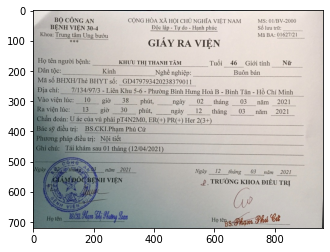

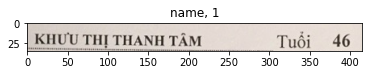

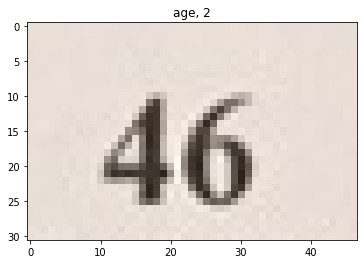

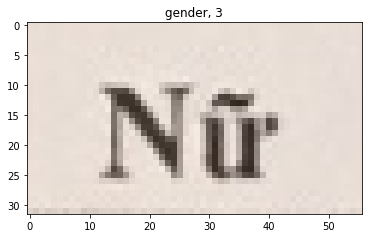

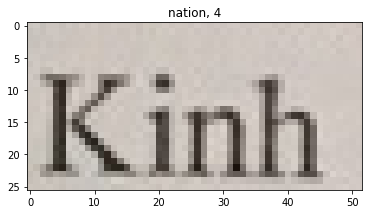

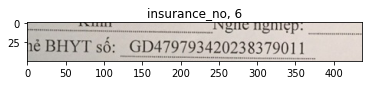

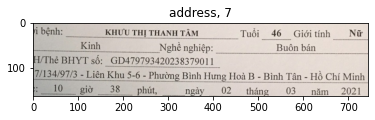

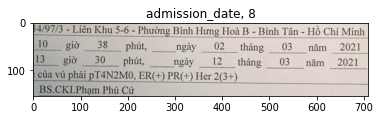

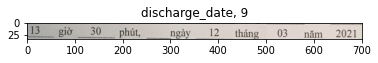

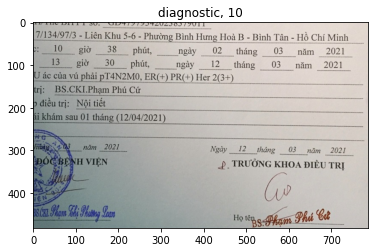

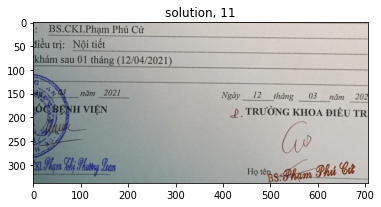

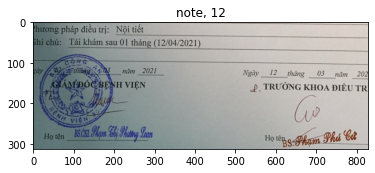

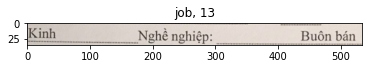

In [5]:
%matplotlib inline
# FUCTION FOR SPLIT FIELD


def split_field_discharge_record(detections, list_class_init, num_classes, crop_image):
    im_height, im_width = crop_image.shape[:2]
    boxes = [[im_height, im_width, 0, 0] for i in range(num_classes)]
    detection_classes = detections['detection_classes']
    detection_boxes  = detections['detection_boxes']
    detection_scores  = detections['detection_scores']
    list_classes = set(detection_classes)
    list_ignore = list_class_init - list_classes
    min_line, max_line = (15, 70)
    print(min_line, max_line)
    for i in range(len(detection_classes)):
        class_id = detection_classes[i]
        (ymin, xmin, ymax, xmax) = (
            detection_boxes[i][0] * im_height, 
            detection_boxes[i][1] * im_width, 
            detection_boxes[i][2] * im_height, 
            detection_boxes[i][3] * im_width
        )
        line_size = (detection_boxes[i][2] -  detection_boxes[i][0]) * im_height
#         print(line_size)
        if line_size < min_line or line_size > max_line:
            continue
        if ymin < boxes[class_id -1][0]: boxes[class_id -1][0] = ymin
        if xmin < boxes[class_id -1][1]: boxes[class_id -1][1] = xmin
        if ymax > boxes[class_id -1][2]: boxes[class_id -1][2] = ymax
        if xmax > boxes[class_id -1][3]: boxes[class_id -1][3] = xmax
            
    boxes = np.array(boxes).astype(int)
    
#     for i in range(len(boxes)):
#         if i <= 4 or i == 12:
#             continue
#         else:
#             if boxes[i+1][2] > boxes[i][2] and i not in list_ignore: boxes[i+1][0] = boxes[i][2]
            
#         if boxes[6][2] > boxes[5][2] and 5 not in list_ignore: boxes[6][0] = boxes[5][2]
#         if boxes[7][2] > boxes[6][2] and 6 not in list_ignore: 
#             boxes[7][0] = boxes[6][2]
#         if boxes[8][2] > boxes[7][2] and 6 not in list_ignore: 
#             boxes[8][0] = boxes[7][2]
# #         
#     if boxes[9][2] > boxes[8][2]: 
#         boxes[9][0] = boxes[8][2]
#         boxes[9][2] = boxes[9][0] + 50*im_height/720
#     if boxes[10][2] > boxes[9][2]: 
#         boxes[10][0] = boxes[9][2]
#         boxes[10][2] = boxes[10][0] + 50*im_height/720


    return boxes, list_ignore

def crop_and_recog(box):
    end = image[box[0]:box[2], box[1]:box[3]]
    return end

boxes, list_ignore = split_field_discharge_record(detections, list_class_init, num_classes, image)
ocr_helpers.implt(image)
for i in range(len(boxes)):
    class_id = i + 1
    try:
        ocr_helpers.implt(crop_and_recog(boxes[i]), None, category_index[class_id]['name'] + ', ' + str(class_id))
    except:
        pass

# RECOGNITION TEXT OF FIELD BY TRANSFORMER MODEL

In [ ]:
%matplotlib inline
from ai_service import CompletedModel

# for i in range(len(boxes)):
#     class_id = i + 1

model = CompletedModel()

def text_recognition_giay_ra_vien(boxes, list_ignore, image, category_index):
    def crop_and_recog(boxes):
        end = image[boxes[0]:boxes[2], boxes[1]:boxes[3]]
        return end
    list_ans = []
    list_class = []
    for i in range(len(boxes)):
        box = boxes[i]
        class_id = i+1
        print(class_id)
        if class_id in list_ignore:
            list_ignore.remove(class_id)
            continue
        list_ans.append(crop_and_recog(box))
        list_class.append(class_id)
    result = self.model.text_recognition_model.predict_on_batch(np.array(list_ans))
    field_dict = dict()
    for i in range(len(result)):
        field_dict[category_index[list_class[i]]['name']] = result[i]
    return field_dict


text_recognition_giay_ra_vien(boxes, list_ignore, image, category_index)

In [ ]:
    #     try:
#         ocr_helpers.implt(image_end.crop((boxes[i][1], boxes[i][0], boxes[i][3], boxes[i][2])), None, category_index[class_id]['name'])
#     except:
#         print(category_index[class_id]['name'])
#         print("Cannot detect", boxes[i])
#     print('----------------------------------------------------------------------------------')
    
# # SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
# viz_utils.visualize_boxes_and_labels_on_image_array(
#       image_with_detections,
#       detections['detection_boxes'],
#       detections['detection_classes'],
#       detections['detection_scores'],
#       category_index,
#       use_normalized_coordinates=True,
#       max_boxes_to_draw=200,
#       min_score_thresh=MIN_CONF_THRESH,
#       agnostic_mode=False)
# ocr_helpers.implt(image_with_detections, None, 'Draw')